In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

# read the data set
df = pd.read_csv("googleplaystore_clean.csv")
#numeric column in dataset
X_num = pd.DataFrame({
    "Price_num": pd.to_numeric(df["Price"]),
    "Size_MB":   pd.to_numeric(df["Size"]),
    "AndroidMajor": pd.to_numeric(df["Android Ver"]),
})

#log1p on install
# Max log1p(Installs) = 20.7233 (this is log1p(1,000,000,000) max Installs is 1,000,000,000)
y = np.log1p(df["Installs"].astype(float)).values 
print(np.log1p(1000000000))
# print(np.expm1(20.72326583794641))

#split the genres then perform multi hot
G  = df["Genres"].astype(str).str.get_dummies(sep=';').add_prefix("G_")
Cat= pd.get_dummies(df["Category"],prefix="Cat")
Typ= pd.get_dummies(df["Type"], prefix="Type")
CR = pd.get_dummies(df["Content Rating"], prefix="CR")
# A = pd.get_dummies(df["Android Ver"], prefix="ver")
X  = pd.concat([G, Cat, Typ, CR, X_num], axis=1).astype(float).values

# split training and testing
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# feature scalling (standard scaler)
scaler = StandardScaler()
Xtr = scaler.fit_transform(Xtr).astype("float32")
Xte = scaler.transform(Xte).astype("float32")
ytr  = ytr.astype("float32")
yte  = yte.astype("float32")

# plot scatter plot
def plot_graph(y_true, y_pred, title):
    lo = float(min(y_true.min(), y_pred.min()))
    hi = float(max(y_true.max(), y_pred.max()))
    pad = 0.05 * (hi - lo) if hi > lo else 1.0
    lo, hi = lo - pad, hi + pad

    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, s=10, alpha=0.6)
    plt.plot([lo, hi], [lo, hi])  
    plt.xlim(lo, hi)
    plt.ylim(lo, hi)
    plt.xlabel("Actual y ")
    plt.ylabel("Predicted y ")
    plt.title(title)
    plt.show()

# print score
def print_scores(split, y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred)) 
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{split:>5} | MSE={mse:.4f} RMSE={rmse:.4f}  MAE={mae:.4f}  R2={r2:.4f}")



20.72326583794641


Linear Regression

TRAIN | MSE=14.3341 RMSE=3.7860  MAE=3.0833  R2=0.2486
 TEST | MSE=14.9803 RMSE=3.8704  MAE=3.1513  R2=0.2256


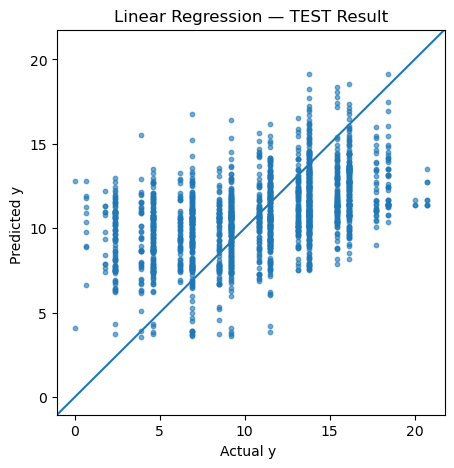

In [3]:
# # MODEL Linear Regression
lr = LinearRegression()
lr.fit(Xtr, ytr)

# make prediction
pred_tr = lr.predict(Xtr)
pred_te = lr.predict(Xte)

print_scores("TRAIN", ytr, pred_tr)
print_scores(" TEST",  yte, pred_te)

# plot graph for test result
plot_graph(yte, pred_te, "Linear Regression — TEST Result")




gradient boost

TRAIN | MSE=11.2778 RMSE=3.3582  MAE=2.6893  R2=0.4088
 TEST | MSE=12.1192 RMSE=3.4813  MAE=2.7743  R2=0.3735


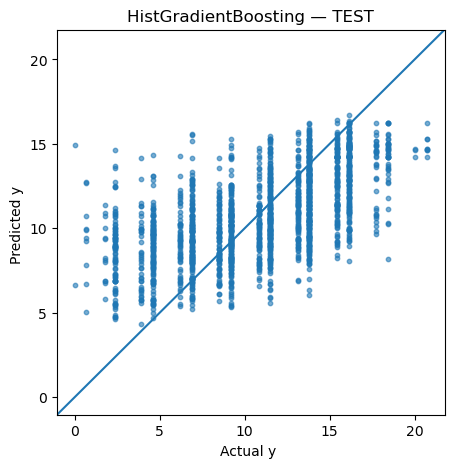

In [12]:
# Import
from sklearn.ensemble import HistGradientBoostingRegressor

# Model 
gb = HistGradientBoostingRegressor(
    learning_rate=0.05,
    max_iter=800,
    early_stopping=True,
    random_state=42
)

#  Fit 
gb.fit(Xtr, ytr)

#  Predict 
pred_tr = gb.predict(Xtr)
pred_te = gb.predict(Xte)

# Evaluate 
print_scores("TRAIN", ytr, pred_tr)
print_scores(" TEST",  yte, pred_te)

# Plot
plot_graph(yte, pred_te, "HistGradientBoosting — TEST")


Permutation Importance (linear regression)

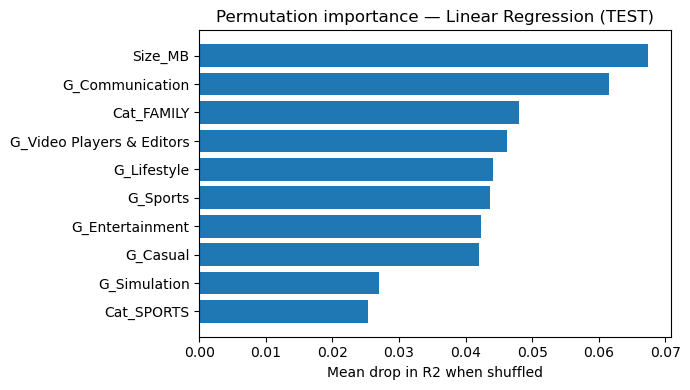

In [96]:
# top 10 permutation importance (Linear Regression) 
# get all the value 
feat_names = np.array(pd.concat([G, Cat, Typ,CR ,X_num], axis=1).columns)

res = permutation_importance(
    lr, Xte, yte,
    scoring="r2",
    n_repeats=10, #shuffle 10 times
    random_state=42,
)
# Sorts features by their average drop in R² from highest to lowest, then takes the top 10 
idx = np.argsort(res.importances_mean)[::-1][:10]
top10 = pd.DataFrame({
    "feature": feat_names[idx], #feature name
    "mean_drop_in_R2": res.importances_mean[idx], #average of R2 drop
})

# bar chart
plt.figure(figsize=(7,4))
plt.barh(top10["feature"][::-1], top10["mean_drop_in_R2"][::-1])
plt.xlabel("Mean drop in R2 when shuffled")
plt.title("Permutation importance — Linear Regression (TEST)")
plt.tight_layout()
plt.show()


Neural Network MLP

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 53.6559 - mae: 5.9303 - mse: 53.6559 - val_loss: 17.7357 - val_mae: 3.4014 - val_mse: 17.7357
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.7500 - mae: 3.2060 - mse: 15.7500 - val_loss: 14.5515 - val_mae: 3.1184 - val_mse: 14.5515
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.6912 - mae: 3.1172 - mse: 14.6912 - val_loss: 14.3172 - val_mae: 3.0859 - val_mse: 14.3172
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.4232 - mae: 3.0922 - mse: 14.4232 - val_loss: 14.2379 - val_mae: 3.0732 - val_mse: 14.2379
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.2720 - mae: 3.0747 - mse: 14.2720 - val_loss: 14.2051 - val_mae: 3.0703 - val_mse: 14.2051
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.1672 - mae: 3.0611 - mse: 14.1672 - val_loss: 14.1805 - val_mae: 3.0675 - val_mse: 14.1805
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14.0879 - mae: 3.0496 - mse: 1

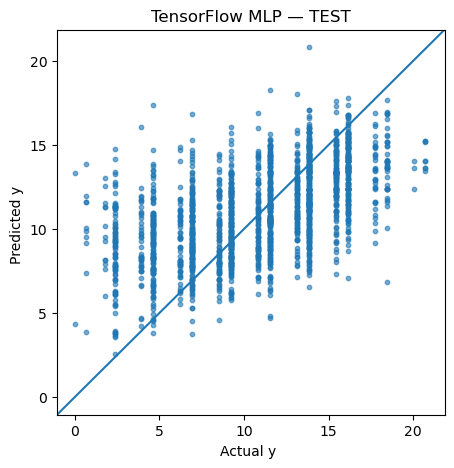

In [8]:
# Tensor flow import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


tf.random.set_seed(42)

# layers
model = keras.Sequential([
    layers.Input(shape=(Xtr.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dense(64,  activation="relu"),
    layers.Dense(1)  # predicting log1p(Installs)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001), # set learning rate
    loss="mse", #cost function
    metrics=["mae", "mse"]
)

# Tuning part
history = model.fit(Xtr, ytr, validation_split=0.1,
                    epochs=50, batch_size=128, verbose=1)

# prediction
pred_tr = model.predict(Xtr)
pred_te = model.predict(Xte)

print_scores("TRAIN", ytr, pred_tr)
print_scores(" TEST", yte, pred_te)

# print scartter plot
plot_graph(yte, pred_te, "TensorFlow MLP — TEST")



61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step
61/61 ━━━━━━━━━━━━

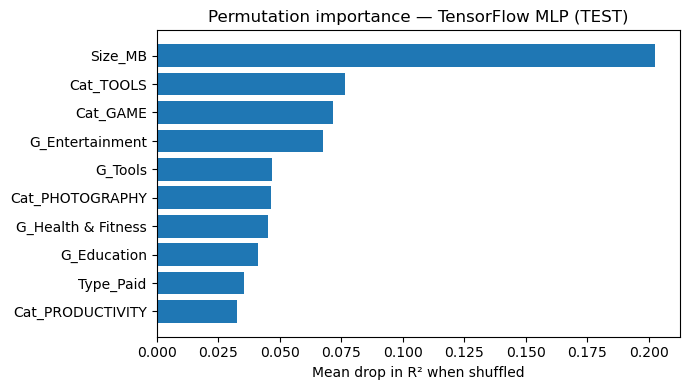

In [103]:
# get all the value 
feat_names = np.array(pd.concat([G, Cat, Typ, CR, X_num], axis=1).columns)

# Custom R2 scorer that works with Keras models
def keras_r2(est, X, y):
    y_pred = est.predict(X)
    return r2_score(y, y_pred)

res_nn = permutation_importance(
    model, Xte, yte,
    scoring=keras_r2,
    n_repeats=10,
    random_state=42,
)

# get the top 10 
idx = np.argsort(res_nn.importances_mean)[::-1][:10]
top10_nn = pd.DataFrame({
    "feature": feat_names[idx],
    "mean_drop_in_R2": res_nn.importances_mean[idx],
})


# bar chart
plt.figure(figsize=(7,4))
plt.barh(top10_nn["feature"][::-1], top10_nn["mean_drop_in_R2"][::-1])
plt.xlabel("Mean drop in R² when shuffled")
plt.title("Permutation importance — TensorFlow MLP (TEST)")
plt.tight_layout()
plt.show()


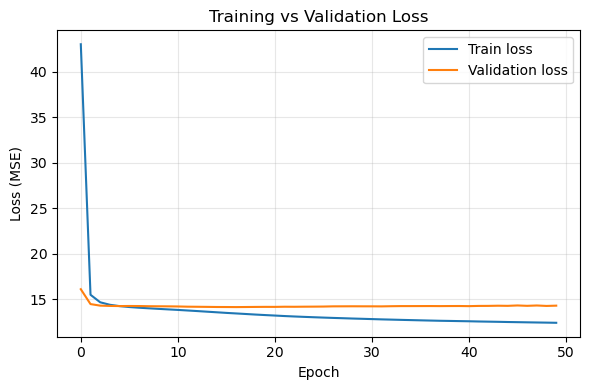

In [5]:
#Training vs Validation Loss
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"],label="Train loss")
plt.plot(history.history["val_loss"],label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Ensemble (Linear Regression with MLP)

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
STACKED RESULTS
STACK — TRAIN | MSE=12.2665 RMSE=3.5024  MAE=2.7814  R2=0.3569
STACK — TEST | MSE=13.2852 RMSE=3.6449  MAE=2.9170  R2=0.3132


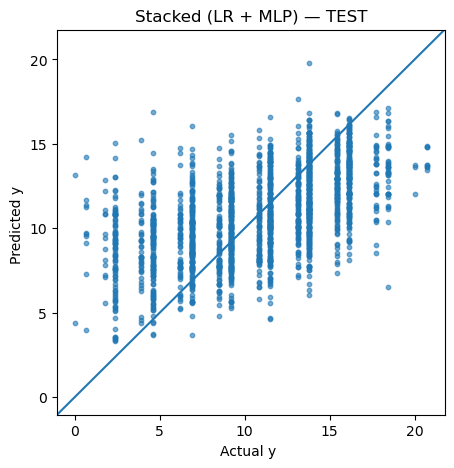

In [102]:
#Stack for ensemble
#Base predictions (Keras gives preds like (N, 1) but sklearn likes (N,). ravel makes both match)
p_lr_tr = np.ravel(lr.predict(Xtr))
p_nn_tr = np.ravel(model.predict(Xtr))

p_lr_te = np.ravel(lr.predict(Xte))
p_nn_te = np.ravel(model.predict(Xte))

# Fit and train
Z_tr = np.column_stack([p_lr_tr, p_nn_tr])   
meta = LinearRegression().fit(Z_tr, ytr)

# predict for training (blender predicts)
pred_stack_tr = meta.predict(Z_tr)

# fit train
Z_te = np.column_stack([p_lr_te, p_nn_te])
#predict for testing (blender predicts)
pred_stack_te = meta.predict(Z_te)

# mae (cost function)
mae_tr = mean_absolute_error(ytr, pred_stack_tr)
mae_te = mean_absolute_error(yte, pred_stack_te)
# print
print("STACKED RESULTS")
print_scores("STACK — TRAIN", ytr, pred_stack_tr)
print_scores("STACK — TEST",  yte, pred_stack_te)

plot_graph(yte, pred_stack_te, "Stacked (LR + MLP) — TEST")
